# Time-Series Generative Adversarial Networks on BATADAL Dataset
- Review source code from the original [TimeGANs](https://github.com/jsyoon0823/TimeGAN), [other](https://towardsdatascience.com/modeling-and-generating-time-series-data-using-timegan-29c00804f54d).
- [BADATAL](https://www.batadal.net/data.html) dataset.
- [Paper](https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html) "Time-series Generative Adversarial Networks" by Yoon et.al. NeurIPS 2019.

In [1]:
# Expand Jupyter Notebook view
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Basic imports
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn related imports
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Tensorflow related imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

2022-05-01 16:32:54.110578: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 16:32:54.110593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Set GPU/CPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("Using CUDA")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("Using CPU")

Using CPU


2022-05-01 16:32:55.343155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 16:32:55.343175: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 16:32:55.343192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


In [5]:
# Set Seaborn Mode
sns.set_style('white')

## 1. Set Experiment Path

In [6]:
results_path = Path('../../results')
if not results_path.exists():
    results_path.mkdir()

In [7]:
log_dir = results_path / f'experiment_{0:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

## 2. Input Data
### 2.1. Training Parameters

In [8]:
seq_len = 24     # number of selected row
n_seq = 26       # number of selected features
batch_size = 128 # number of element per batch

### 2.2. Data Preprocessing

In [9]:
df = pd.read_csv("../../../../../data/batadal_dataset03.csv")

In [10]:
df.dtypes

DATETIME     object
L_T1        float64
L_T2        float64
L_T3        float64
L_T4        float64
L_T5        float64
L_T6        float64
L_T7        float64
F_PU1       float64
S_PU1         int64
F_PU2       float64
S_PU2         int64
F_PU3         int64
S_PU3         int64
F_PU4       float64
S_PU4         int64
F_PU5         int64
S_PU5         int64
F_PU6       float64
S_PU6         int64
F_PU7       float64
S_PU7         int64
F_PU8       float64
S_PU8         int64
F_PU9         int64
S_PU9         int64
F_PU10      float64
S_PU10        int64
F_PU11      float64
S_PU11        int64
F_V2        float64
S_V2          int64
P_J280      float64
P_J269      float64
P_J300      float64
P_J256      float64
P_J289      float64
P_J415      float64
P_J302      float64
P_J306      float64
P_J307      float64
P_J317      float64
P_J14       float64
P_J422      float64
ATT_FLAG      int64
dtype: object

In [11]:
# Get only float values
df = df[['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
         'F_PU1', 'F_PU2', 'F_PU4', 'F_PU7', 'F_PU8', 'F_PU10',
         'F_V2',
         'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 
         'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']]

In [12]:
df.shape

(8761, 26)

In [13]:
features = list(df.columns)
print(f"Attributes names: {features}")

Attributes names: ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'F_PU2', 'F_PU4', 'F_PU7', 'F_PU8', 'F_PU10', 'F_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']


### 2.3. Plot Attributes of Time Series

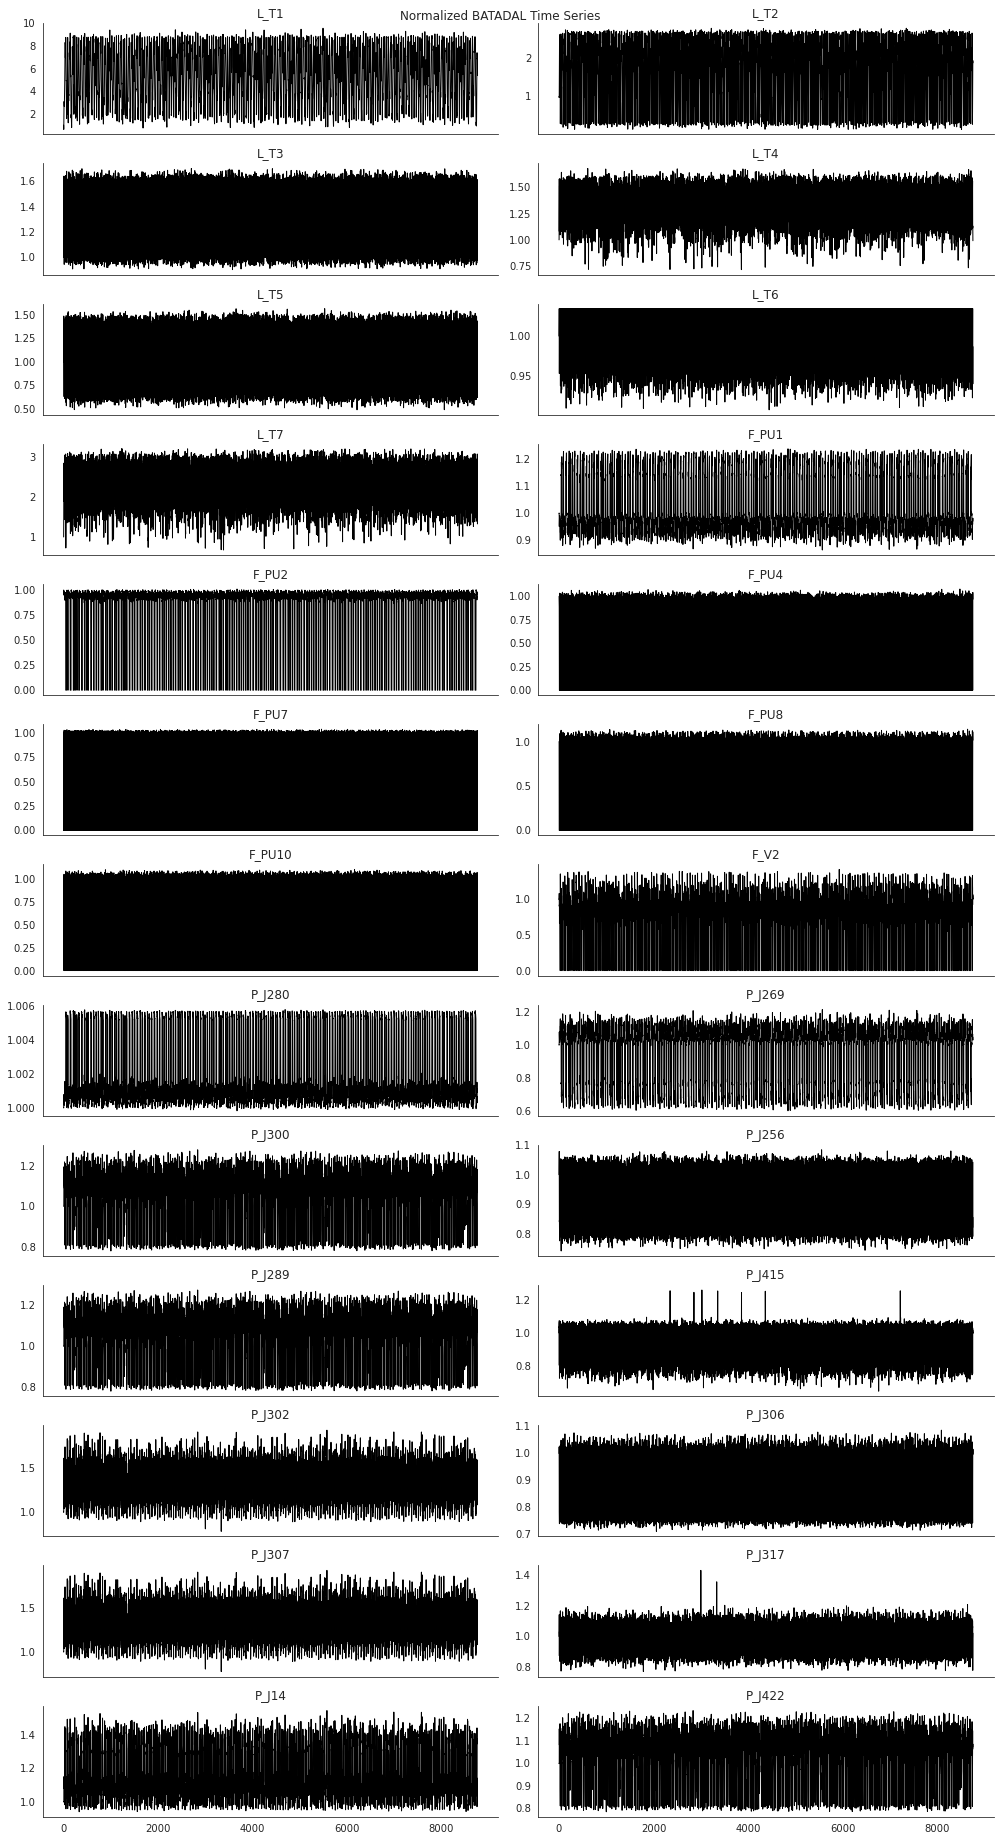

In [14]:
axes = df.div(df.iloc[0]).plot(subplots=True,
                              figsize=(14,26),
                              layout=(13,2),
                              title=features,
                              legend=False,
                              rot=0,
                              lw=1,
                              color='k')

for ax in axes.flatten():
    ax.set_xlabel("")
    
plt.suptitle("Normalized BATADAL Time Series")
plt.gcf().tight_layout()
sns.despine();

### 2.4. Correlationn between Attributes

See within a batch of synthetic data we can get the same attribution?

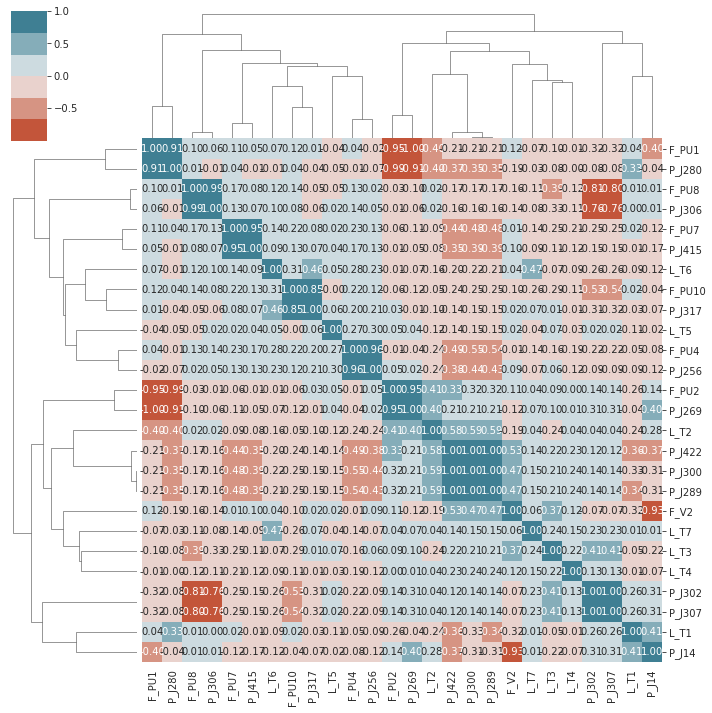

In [15]:
sns.clustermap(df.corr(),
              annot=True,
              fmt='0.2f',
              cmap=sns.diverging_palette(h_neg=20,
                                         h_pos=220), center=0)

### 2.5. Normalize Data

In [16]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

### 2.6. Create Rolling Window Sequences

This will make the data from time series to IID

In [17]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [18]:
np.asarray(data).shape

(8737, 24, 26)

## 3. Data Processing
We want to set up a generator to feed a Dataset that continues to call the random number generator as long as necessary and produce the desired batch size.

In [19]:
real_series = (tf.data.Dataset
                .from_tensor_slices(data)
                .shuffle(buffer_size=n_windows)
                .batch(batch_size))

real_series_iter = iter(real_series.repeat())

2022-05-01 16:33:00.090072: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [21]:
random_series = iter(tf.data.Dataset
                        .from_generator(make_random_data, output_types=tf.float32)
                        .batch(batch_size)
                        .repeat())

## 4. TimeGAN Component

In [22]:
hidden_dim = 24
num_layers = 3

# logger 
writer = tf.summary.create_file_writer(log_dir.as_posix())

### 4.1. Input Place Holders

In [23]:
X = Input(shape=[seq_len, n_seq], name="RealData")
Z = Input(shape=[seq_len, n_seq], name='RandomData')

### 4.2. RNN Block Generator

In [24]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                          return_sequences=True,
                          name=f'GRU_{i + 1}') for i in range(n_layers)] + 
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

### 4.3. Embedder & Recovery

In [25]:
embedder = make_rnn(n_layers=3,
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim,
                    name='Embedder')
recovery = make_rnn(n_layers=3,
                    hidden_units=hidden_dim,
                    output_units=n_seq,
                    name='Recovery')

### 4.4. Generator & Discriminator

In [26]:
generator = make_rnn(n_layers=3,
                     hidden_units=hidden_dim,
                     output_units=hidden_dim,
                     name='Generator')

discriminator = make_rnn(n_layers=3,
                         hidden_units=hidden_dim,
                         output_units=1,
                         name='Discriminator')

supervisor = make_rnn(n_layers=2,
                      hidden_units=hidden_dim,
                      output_units=hidden_dim,
                      name='Supervisor')

## 5. TimeGAN Training Setup

In [27]:
train_steps = 5 #10000
gamma = 1

In [28]:
# Loss functions
mse = MeanSquaredError()
bce = BinaryCrossentropy()

### 5.1 Autoencoder Training

In [29]:
# Architecture
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name="Autoencoder")

In [30]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 26)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            11544     
                                                                 
 Recovery (Sequential)       (None, 24, 26)            11450     
                                                                 
Total params: 22,994
Trainable params: 22,994
Non-trainable params: 0
_________________________________________________________________


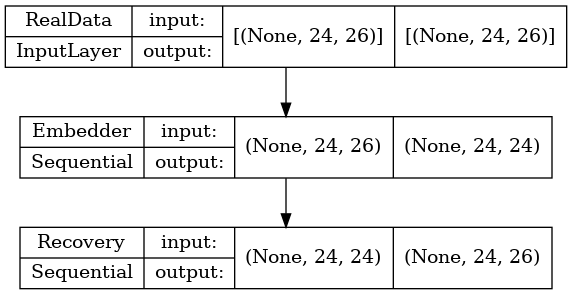

In [31]:
plot_model(autoencoder,
           to_file=('../../../../imgs/autoencoder_batadal.png'),
           show_shapes=True)

In [32]:
# Optimizer
autoencoder_optimizer = Adam()

In [33]:
# Training Step
@tf.function

def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)
    
    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [34]:
# Training Loop
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


### 5.2. Supervised Training

In [35]:
# Optimizer 
supervisor_optimizer = Adam()

In [36]:
# Training Steps
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1: , :], h_hat_supervised[:, :-1, :])
        
    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [37]:
# Training Loop
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


### 5.3. Joint Training 

### Generator

In [38]:
# Adversarial Architectture - Supervised
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [39]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 26)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11544     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 30,169
Trainable params: 30,169
Non-trainable params: 0
_________________________________________________________________


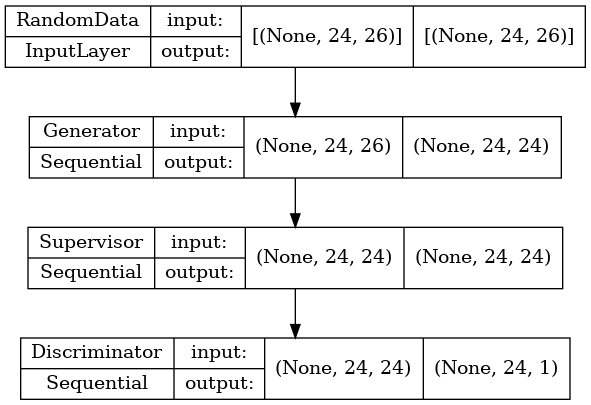

In [40]:
plot_model(adversarial_supervised, 
            to_file=('../../../../imgs/generator_batadal.png'),
           show_shapes=True)

In [41]:
# Adversarial Architecture in Latent Space
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [42]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 26)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11544     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 22,369
Trainable params: 22,369
Non-trainable params: 0
_________________________________________________________________


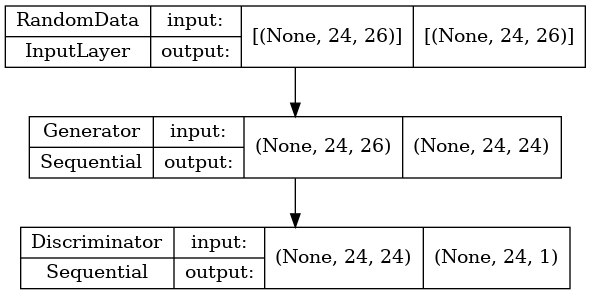

In [43]:
plot_model(adversarial_emb, 
           to_file=('../../../../imgs/adversarial_emb_batadal.png'),
           show_shapes=True)

In [44]:
# Mean & Variance Loss
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [45]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 26)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            11544     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 26)            11450     
                                                                 
Total params: 30,794
Trainable params: 30,794
Non-trainable params: 0
_________________________________________________________________


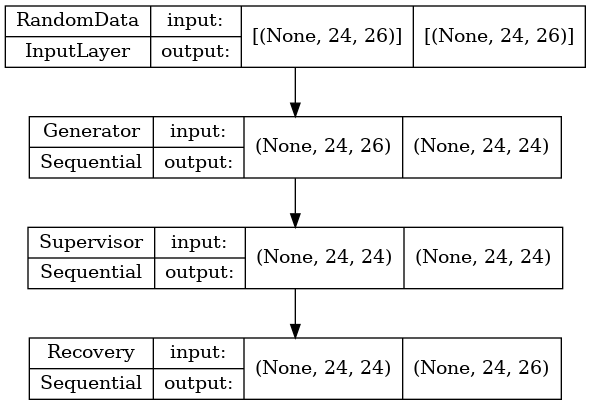

In [46]:
plot_model(synthetic_data, 
           to_file=('../../../../imgs/synthetic_batadal.png'),
           show_shapes=True)

In [47]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

### Discriminator

In [48]:
# Architecture for real data
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [49]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 26)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            11544     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 22,369
Trainable params: 22,369
Non-trainable params: 0
_________________________________________________________________


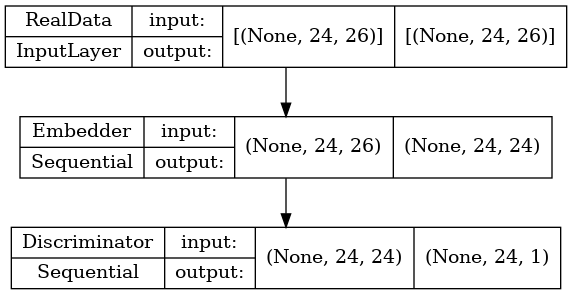

In [50]:
plot_model(discriminator_model, 
           to_file=('../../../../imgs/discriminator_batadal.png'),
           show_shapes=True)

### Optimizers

In [51]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## 6. Training Steps

### 6.1. Generator

In [52]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

### 6.2. Embedding 

In [53]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

### 6.3. Discriminator

In [54]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [55]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

### 6.4. Final Training Loop

In [56]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.0269 | g_loss_u: 0.7837 | g_loss_s: 0.0044 | g_loss_v: 0.3578 | e_loss_t0: 0.3058


## 7. Log Synthetic Data Generator

In [57]:
synthetic_data.save(log_dir / 'synthetic_data_batadal')

2022-05-01 16:34:06.465102: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../results/experiment_00/synthetic_data_batadal/assets


INFO:tensorflow:Assets written to: ../../results/experiment_00/synthetic_data_batadal/assets


## 8. Generate Synthetic Data

In [58]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [59]:
len(generated_data)

68

In [60]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(8704, 24, 26)

In [61]:
np.save(log_dir / 'generated_data_batadal.npy', generated_data)

### 8.1. Rescale

In [62]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(8704, 24, 26)

### 8.2. Plot Sample Series

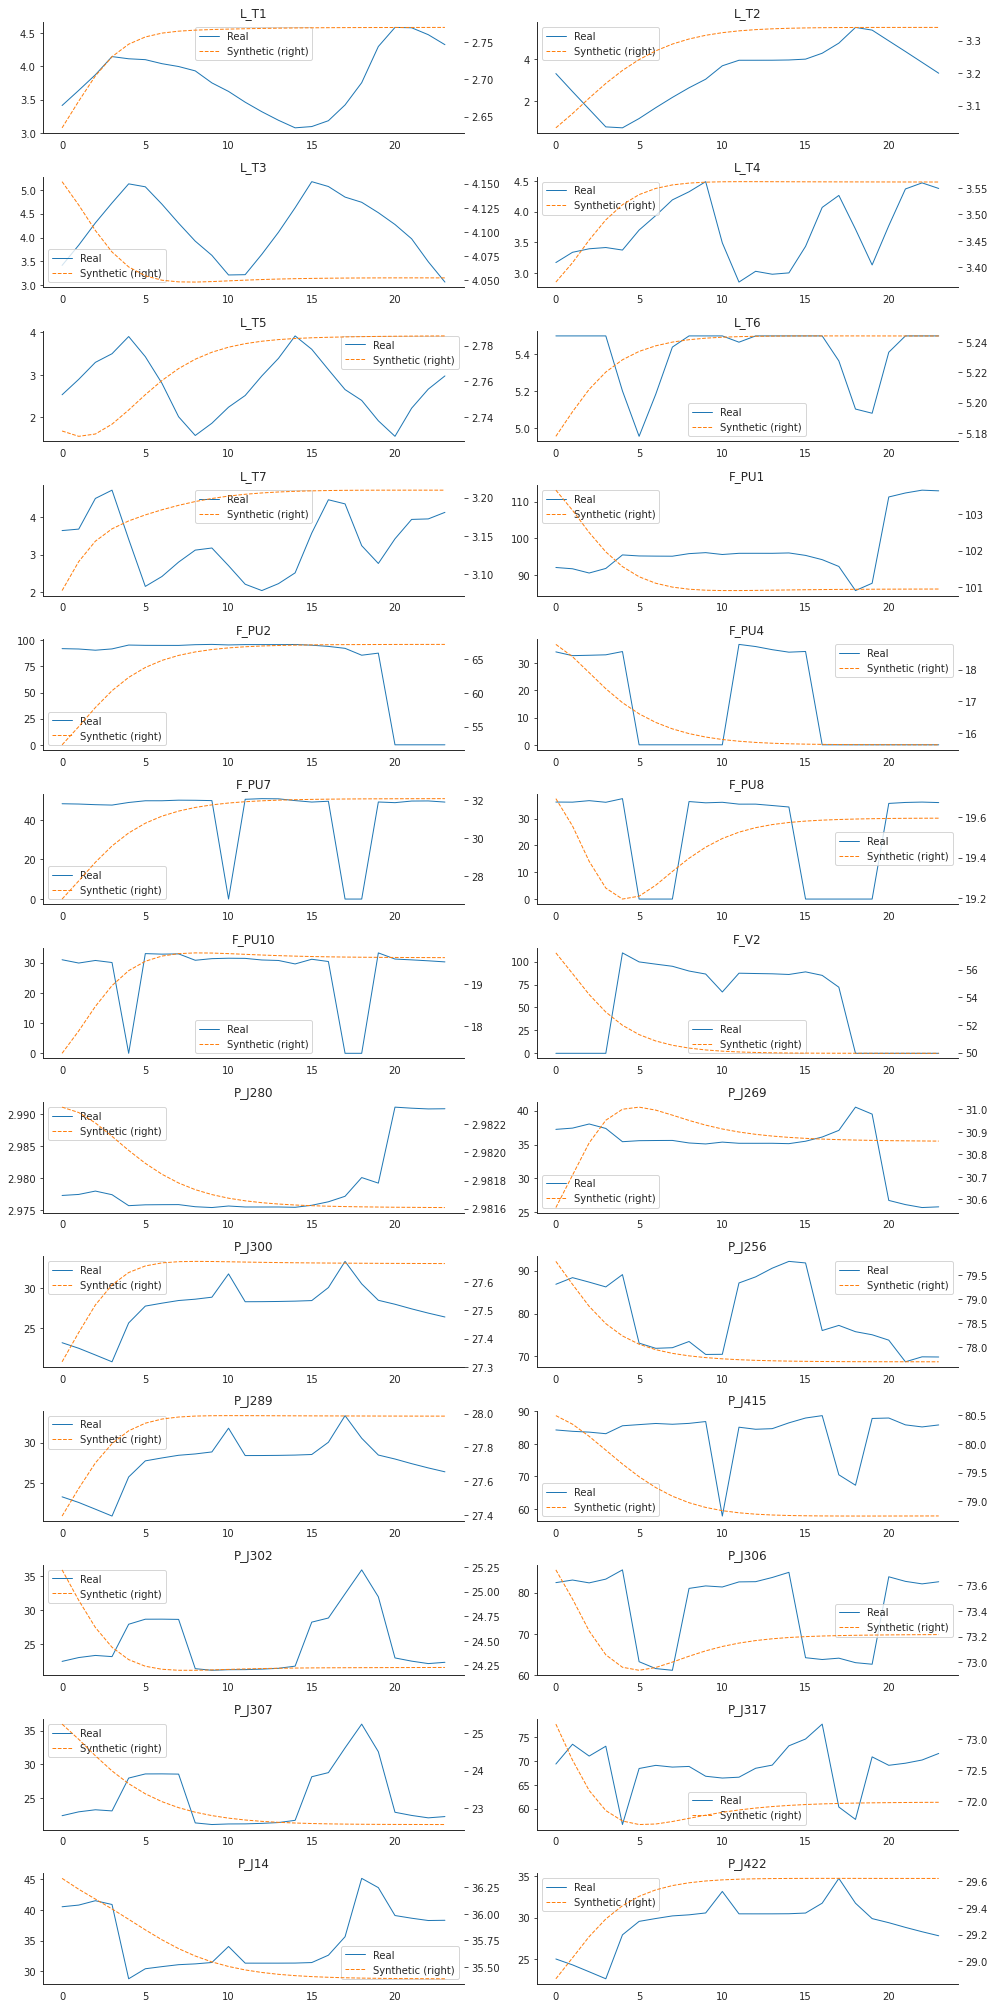

In [63]:
fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(14, 28))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(features):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()